Reference: [49] PyTorch [Tabular] —Multiclass Classification

https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab 

In [ ]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
plt.style.use("ggplot")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read Data
df = pd.read_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/08_data_pre_processing_for_openface/ekman/all_videos_emotion_merged_without_success0.csv")
df.head()

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,...,p_32,p_33,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,filename,emotion,videoname
0,1,0,0.00,0.98,1,0.217484,0.400964,-0.889904,0.050022,0.410571,-0.910455,0.148,0.423,688.7,689.9,694.0,698.6,700.9,700.0,695.6,691.1,681.6,684.7,688.8,693.5,698.2,701.8,704.6,702.1,698.2,693.6,689.1,684.9,693.1,695.0,696.8,697.3,696.3,694.3,692.6,...,-0.107,0.160,0.42,0.0,0.0,0.0,0.08,2.46,0.69,0.96,0.86,0.17,1.33,0.0,0.37,0.0,1.53,1.38,0.98,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,anger,video01
1,2,0,0.04,0.98,1,0.223496,0.397311,-0.890052,0.019622,0.406862,-0.913279,0.134,0.419,687.7,689.0,693.2,697.8,700.2,699.1,694.7,690.1,680.3,683.5,687.7,692.6,697.4,701.1,703.7,701.2,697.3,692.7,688.0,683.7,692.1,694.1,695.9,696.5,695.5,693.5,691.7,...,-0.041,0.100,0.46,0.0,0.0,0.0,0.17,2.79,0.65,1.04,1.01,0.51,1.47,0.0,0.03,0.0,1.47,1.27,0.78,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,anger,video01
2,3,0,0.08,0.98,1,0.220156,0.372378,-0.901591,0.014346,0.395123,-0.918516,0.128,0.399,686.9,688.3,692.5,697.1,699.3,698.2,693.7,689.1,679.7,682.8,686.9,691.8,696.6,700.3,703.0,700.3,696.4,691.7,687.2,683.0,691.3,693.2,695.1,695.7,694.7,692.7,690.9,...,-0.044,0.102,0.39,0.0,0.0,0.0,0.15,2.77,0.57,1.06,0.88,0.82,1.48,0.0,0.08,0.0,1.40,1.15,0.70,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,anger,video01
3,4,0,0.12,0.98,1,0.232741,0.351699,-0.906719,0.029666,0.370821,-0.928231,0.142,0.375,684.7,686.3,690.5,695.0,697.1,695.8,691.3,686.8,677.4,680.6,684.8,689.6,694.4,698.0,700.6,697.9,694.0,689.5,684.9,680.7,689.0,690.9,692.8,693.4,692.5,690.6,688.8,...,-0.029,0.101,0.37,0.0,0.0,0.0,0.22,2.50,0.60,0.79,1.01,1.16,1.38,0.0,0.00,0.0,1.31,0.98,0.65,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,anger,video01
4,5,0,0.16,0.98,1,0.220415,0.332130,-0.917119,0.030642,0.365490,-0.930311,0.135,0.361,682.3,683.9,688.2,692.6,694.6,693.3,688.7,684.3,675.2,678.5,682.7,687.5,692.1,695.7,698.2,695.6,691.7,687.1,682.6,678.4,686.5,688.4,690.3,691.0,690.1,688.2,686.3,...,-0.037,0.123,0.38,0.0,0.0,0.0,0.29,2.99,0.57,0.86,0.67,0.59,1.40,0.0,0.00,0.0,1.00,0.88,0.89,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,anger,video01


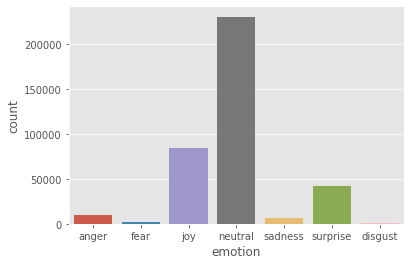

In [ ]:
# EDA and Preprocessing
# Class Distribution
sns.countplot(x = 'emotion', data=df)

In [ ]:
# Encode Output Class
class2idx = {
    'anger':0,
    'joy':1,
    'neutral':2,
    'surprise':3,
    'disgust':4,
    'sadness':5,
    'fear':6
}

idx2class = {v: k for k, v in class2idx.items()}

df['emotion'].replace(class2idx, inplace=True)

In [ ]:
df.head()

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,...,p_32,p_33,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,filename,emotion,videoname
0,1,0,0.00,0.98,1,0.217484,0.400964,-0.889904,0.050022,0.410571,-0.910455,0.148,0.423,688.7,689.9,694.0,698.6,700.9,700.0,695.6,691.1,681.6,684.7,688.8,693.5,698.2,701.8,704.6,702.1,698.2,693.6,689.1,684.9,693.1,695.0,696.8,697.3,696.3,694.3,692.6,...,-0.107,0.160,0.42,0.0,0.0,0.0,0.08,2.46,0.69,0.96,0.86,0.17,1.33,0.0,0.37,0.0,1.53,1.38,0.98,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,0,video01
1,2,0,0.04,0.98,1,0.223496,0.397311,-0.890052,0.019622,0.406862,-0.913279,0.134,0.419,687.7,689.0,693.2,697.8,700.2,699.1,694.7,690.1,680.3,683.5,687.7,692.6,697.4,701.1,703.7,701.2,697.3,692.7,688.0,683.7,692.1,694.1,695.9,696.5,695.5,693.5,691.7,...,-0.041,0.100,0.46,0.0,0.0,0.0,0.17,2.79,0.65,1.04,1.01,0.51,1.47,0.0,0.03,0.0,1.47,1.27,0.78,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,0,video01
2,3,0,0.08,0.98,1,0.220156,0.372378,-0.901591,0.014346,0.395123,-0.918516,0.128,0.399,686.9,688.3,692.5,697.1,699.3,698.2,693.7,689.1,679.7,682.8,686.9,691.8,696.6,700.3,703.0,700.3,696.4,691.7,687.2,683.0,691.3,693.2,695.1,695.7,694.7,692.7,690.9,...,-0.044,0.102,0.39,0.0,0.0,0.0,0.15,2.77,0.57,1.06,0.88,0.82,1.48,0.0,0.08,0.0,1.40,1.15,0.70,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,0,video01
3,4,0,0.12,0.98,1,0.232741,0.351699,-0.906719,0.029666,0.370821,-0.928231,0.142,0.375,684.7,686.3,690.5,695.0,697.1,695.8,691.3,686.8,677.4,680.6,684.8,689.6,694.4,698.0,700.6,697.9,694.0,689.5,684.9,680.7,689.0,690.9,692.8,693.4,692.5,690.6,688.8,...,-0.029,0.101,0.37,0.0,0.0,0.0,0.22,2.50,0.60,0.79,1.01,1.16,1.38,0.0,0.00,0.0,1.31,0.98,0.65,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,0,video01
4,5,0,0.16,0.98,1,0.220415,0.332130,-0.917119,0.030642,0.365490,-0.930311,0.135,0.361,682.3,683.9,688.2,692.6,694.6,693.3,688.7,684.3,675.2,678.5,682.7,687.5,692.1,695.7,698.2,695.6,691.7,687.1,682.6,678.4,686.5,688.4,690.3,691.0,690.1,688.2,686.3,...,-0.037,0.123,0.38,0.0,0.0,0.0,0.29,2.99,0.57,0.86,0.67,0.59,1.40,0.0,0.00,0.0,1.00,0.88,0.89,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,0,video01


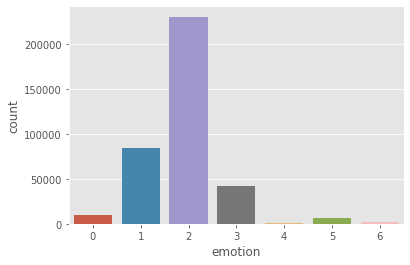

In [ ]:
# EDA and Preprocessing
# Class Distribution
sns.countplot(x = 'emotion', data=df)

In [ ]:
# Renaming a column
newcolumns = list(df.columns)
newcolumns[-1], newcolumns[-2] = newcolumns[-2], newcolumns[-1]
print (newcolumns)

['frame', 'face_id', 'timestamp', 'confidence', 'success', 'gaze_0_x', 'gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z', 'gaze_angle_x', 'gaze_angle_y', 'eye_lmk_x_0', 'eye_lmk_x_1', 'eye_lmk_x_2', 'eye_lmk_x_3', 'eye_lmk_x_4', 'eye_lmk_x_5', 'eye_lmk_x_6', 'eye_lmk_x_7', 'eye_lmk_x_8', 'eye_lmk_x_9', 'eye_lmk_x_10', 'eye_lmk_x_11', 'eye_lmk_x_12', 'eye_lmk_x_13', 'eye_lmk_x_14', 'eye_lmk_x_15', 'eye_lmk_x_16', 'eye_lmk_x_17', 'eye_lmk_x_18', 'eye_lmk_x_19', 'eye_lmk_x_20', 'eye_lmk_x_21', 'eye_lmk_x_22', 'eye_lmk_x_23', 'eye_lmk_x_24', 'eye_lmk_x_25', 'eye_lmk_x_26', 'eye_lmk_x_27', 'eye_lmk_x_28', 'eye_lmk_x_29', 'eye_lmk_x_30', 'eye_lmk_x_31', 'eye_lmk_x_32', 'eye_lmk_x_33', 'eye_lmk_x_34', 'eye_lmk_x_35', 'eye_lmk_x_36', 'eye_lmk_x_37', 'eye_lmk_x_38', 'eye_lmk_x_39', 'eye_lmk_x_40', 'eye_lmk_x_41', 'eye_lmk_x_42', 'eye_lmk_x_43', 'eye_lmk_x_44', 'eye_lmk_x_45', 'eye_lmk_x_46', 'eye_lmk_x_47', 'eye_lmk_x_48', 'eye_lmk_x_49', 'eye_lmk_x_50', 'eye_lmk_x_51', 'eye_lmk_x_52',

In [ ]:
df = df.reindex(columns=newcolumns)
df.head()

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,...,p_32,p_33,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,filename,videoname,emotion
0,1,0,0.00,0.98,1,0.217484,0.400964,-0.889904,0.050022,0.410571,-0.910455,0.148,0.423,688.7,689.9,694.0,698.6,700.9,700.0,695.6,691.1,681.6,684.7,688.8,693.5,698.2,701.8,704.6,702.1,698.2,693.6,689.1,684.9,693.1,695.0,696.8,697.3,696.3,694.3,692.6,...,-0.107,0.160,0.42,0.0,0.0,0.0,0.08,2.46,0.69,0.96,0.86,0.17,1.33,0.0,0.37,0.0,1.53,1.38,0.98,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,video01,0
1,2,0,0.04,0.98,1,0.223496,0.397311,-0.890052,0.019622,0.406862,-0.913279,0.134,0.419,687.7,689.0,693.2,697.8,700.2,699.1,694.7,690.1,680.3,683.5,687.7,692.6,697.4,701.1,703.7,701.2,697.3,692.7,688.0,683.7,692.1,694.1,695.9,696.5,695.5,693.5,691.7,...,-0.041,0.100,0.46,0.0,0.0,0.0,0.17,2.79,0.65,1.04,1.01,0.51,1.47,0.0,0.03,0.0,1.47,1.27,0.78,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,video01,0
2,3,0,0.08,0.98,1,0.220156,0.372378,-0.901591,0.014346,0.395123,-0.918516,0.128,0.399,686.9,688.3,692.5,697.1,699.3,698.2,693.7,689.1,679.7,682.8,686.9,691.8,696.6,700.3,703.0,700.3,696.4,691.7,687.2,683.0,691.3,693.2,695.1,695.7,694.7,692.7,690.9,...,-0.044,0.102,0.39,0.0,0.0,0.0,0.15,2.77,0.57,1.06,0.88,0.82,1.48,0.0,0.08,0.0,1.40,1.15,0.70,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,video01,0
3,4,0,0.12,0.98,1,0.232741,0.351699,-0.906719,0.029666,0.370821,-0.928231,0.142,0.375,684.7,686.3,690.5,695.0,697.1,695.8,691.3,686.8,677.4,680.6,684.8,689.6,694.4,698.0,700.6,697.9,694.0,689.5,684.9,680.7,689.0,690.9,692.8,693.4,692.5,690.6,688.8,...,-0.029,0.101,0.37,0.0,0.0,0.0,0.22,2.50,0.60,0.79,1.01,1.16,1.38,0.0,0.00,0.0,1.31,0.98,0.65,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,video01,0
4,5,0,0.16,0.98,1,0.220415,0.332130,-0.917119,0.030642,0.365490,-0.930311,0.135,0.361,682.3,683.9,688.2,692.6,694.6,693.3,688.7,684.3,675.2,678.5,682.7,687.5,692.1,695.7,698.2,695.6,691.7,687.1,682.6,678.4,686.5,688.4,690.3,691.0,690.1,688.2,686.3,...,-0.037,0.123,0.38,0.0,0.0,0.0,0.29,2.99,0.57,0.86,0.67,0.59,1.40,0.0,0.00,0.0,1.00,0.88,0.89,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,video01,0


In [ ]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
print (X.head())
print (y.head())

   frame  face_id  timestamp  ...  AU45_c             filename  videoname
0      1        0       0.00  ...     1.0  output_video107.csv    video01
1      2        0       0.04  ...     1.0  output_video107.csv    video01
2      3        0       0.08  ...     1.0  output_video107.csv    video01
3      4        0       0.12  ...     1.0  output_video107.csv    video01
4      5        0       0.16  ...     1.0  output_video107.csv    video01

[5 rows x 716 columns]
0    0
1    0
2    0
3    0
4    0
Name: emotion, dtype: int64


In [ ]:
# Prepare Train — Validation — Test dataset
# Split into (train + val) and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split train into train + val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [ ]:
# Pre-processing :remove 'frame', 'filename' and 'videoname'
X_trainval = X_trainval.drop(['frame', 'filename', 'videoname'], axis=1)
X_test_temp = X_test.copy()
X_test = X_test.drop(['frame', 'filename', 'videoname'], axis=1)
X_train = X_train.drop(['frame', 'filename', 'videoname'], axis=1)
X_val = X_val.drop(['frame', 'filename', 'videoname'], axis=1)
X_train.head()

,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,eye_lmk_x_27,...,p_29,p_30,p_31,p_32,p_33,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
172882,0,73.200,0.98,1,-0.005643,0.380691,-0.924685,-0.197444,0.360831,-0.911492,-0.110,0.384,450.9,453.2,458.5,463.6,465.5,463.6,457.9,452.8,445.3,448.7,453.1,458.5,464.0,468.7,472.3,468.5,463.3,457.7,452.6,448.3,456.1,458.3,460.6,461.6,460.8,458.5,456.2,455.2,...,-0.201,0.374,-0.128,0.129,0.285,1.02,0.80,0.52,0.00,0.29,1.21,0.10,0.97,1.09,0.00,0.54,0.00,0.56,0.0,0.34,0.50,0.90,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
62415,0,0.583,0.93,1,0.211115,0.404112,-0.890013,0.062248,0.388478,-0.919353,0.150,0.413,596.4,597.7,600.2,602.4,603.0,601.8,599.2,597.0,592.9,594.6,596.9,599.5,602.0,603.8,604.9,603.3,601.1,598.7,596.4,594.4,598.5,599.4,600.5,601.1,600.8,599.9,598.8,598.2,...,-0.025,-0.003,-0.020,0.028,-0.007,0.37,1.28,0.00,0.00,1.04,0.00,0.00,2.80,1.86,1.30,0.84,0.72,0.00,0.0,2.58,0.95,0.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
142990,0,215.133,0.98,1,0.525501,0.271795,-0.806211,0.401100,0.251642,-0.880792,0.502,0.301,416.8,418.4,421.1,423.3,423.8,422.3,419.5,417.2,412.6,414.8,417.5,420.5,423.0,424.6,425.4,423.8,421.7,419.2,416.6,414.3,418.8,419.8,421.0,421.7,421.5,420.5,419.3,418.6,...,0.001,-0.004,0.017,0.008,-0.002,0.93,0.00,0.44,1.44,0.00,1.88,0.00,0.21,0.42,0.00,0.58,0.00,0.00,0.0,0.00,0.00,0.00,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
259741,0,1.268,0.98,1,0.263826,0.353368,-0.897512,0.134330,0.392797,-0.909761,0.217,0.392,574.5,575.0,577.9,581.6,583.9,583.8,580.6,576.9,570.5,572.1,574.7,578.2,581.9,585.1,587.6,585.7,582.8,579.4,576.1,573.0,578.2,579.9,581.1,581.3,580.3,578.7,577.4,577.2,...,-0.062,-0.106,-0.026,-0.036,0.051,0.00,0.00,0.14,0.60,0.48,2.26,1.29,1.05,1.17,0.06,0.44,0.70,0.21,0.0,2.00,1.56,0.10,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
88223,1,2.033,0.98,1,0.459628,0.222872,-0.859692,0.348886,0.166325,-0.922288,0.426,0.215,493.8,495.8,501.0,506.3,508.7,507.0,501.6,496.2,485.2,489.2,494.2,499.9,505.4,509.5,512.4,509.3,504.8,499.4,493.9,489.0,498.7,501.2,503.5,504.4,503.3,500.9,498.6,497.7,...,0.132,-0.021,-0.036,-0.154,-0.031,0.88,0.00,0.00,0.40,0.42,0.00,0.05,0.00,0.49,0.23,0.54,0.18,2.99,0.0,0.00,0.00,1.44,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Normalize Input
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)
X_test_temp, y_test = np.array(X_test_temp), np.array(y_test)

In [ ]:
def get_class_distribution(obj):
    count_dict = {
        "anger": 0,
        "joy": 0,
        "neutral": 0,
        "surprise": 0,
        "disgust":0,
        "sadness": 0,
        "fear": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['anger'] += 1
        elif i == 1: 
            count_dict['joy'] += 1
        elif i == 2: 
            count_dict['neutral'] += 1
        elif i == 3: 
            count_dict['surprise'] += 1
        elif i == 4: 
            count_dict['disgust'] += 1  
        elif i == 5: 
            count_dict['sadness'] += 1
        elif i == 6:
            count_dict['fear'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

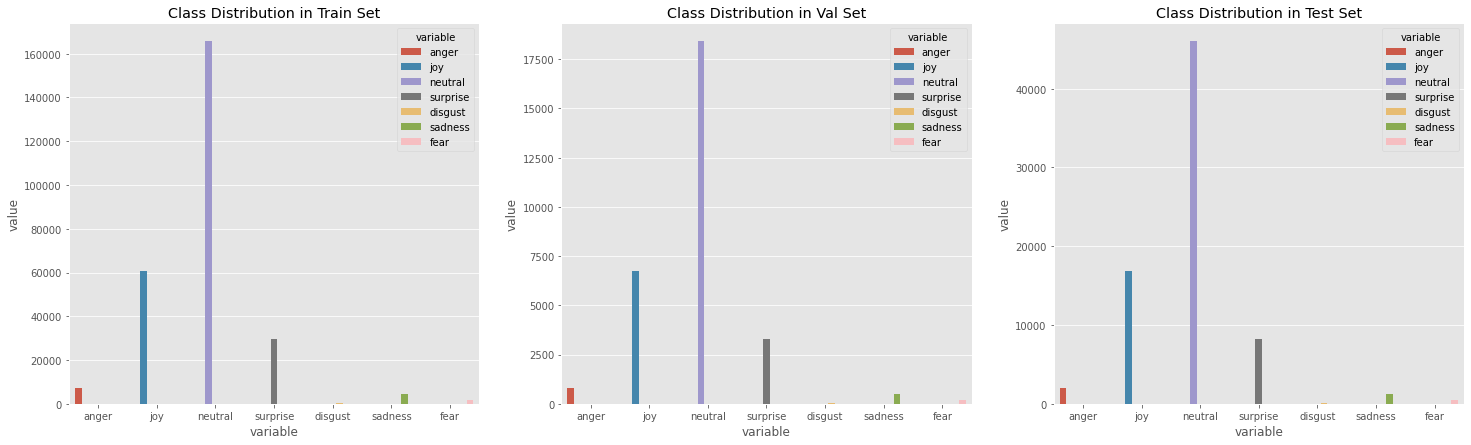

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

Text(0.5, 1.0, 'Class Distribution in Test Set')

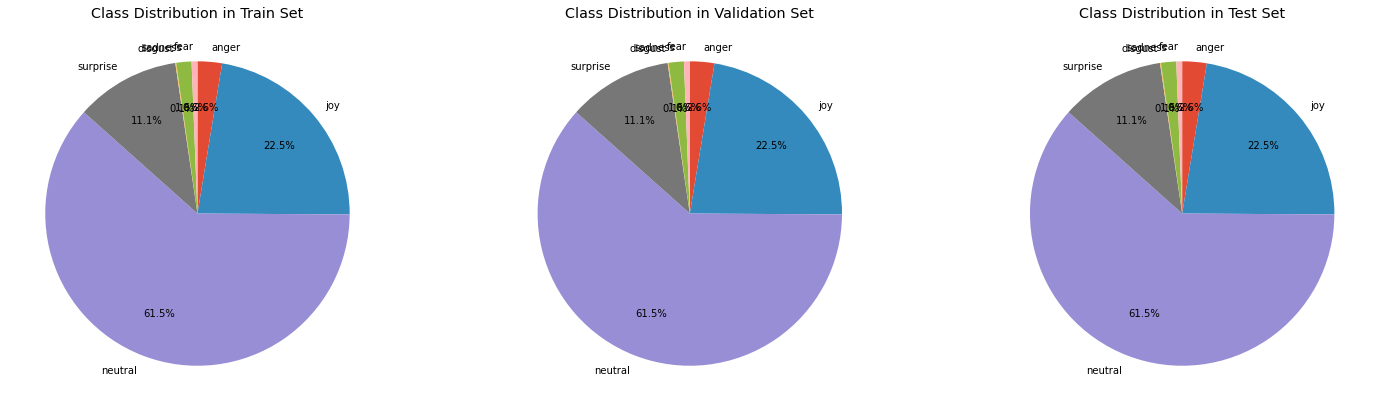

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
axes[0].pie((pd.DataFrame.from_dict([get_class_distribution(y_train)])).melt()["value"],
       labels=(pd.DataFrame.from_dict([get_class_distribution(y_train)])).melt()["variable"], counterclock=False, startangle=90,autopct='%1.1f%%', pctdistance=0.7)
axes[0].set_title("Class Distribution in Train Set")

# Validation
axes[1].pie((pd.DataFrame.from_dict([get_class_distribution(y_val)])).melt()["value"],
       labels=(pd.DataFrame.from_dict([get_class_distribution(y_val)])).melt()["variable"], counterclock=False, startangle=90,autopct='%1.1f%%', pctdistance=0.7)
axes[1].set_title("Class Distribution in Validation Set")
# Test
axes[2].pie((pd.DataFrame.from_dict([get_class_distribution(y_test)])).melt()["value"],
       labels=(pd.DataFrame.from_dict([get_class_distribution(y_test)])).melt()["variable"], counterclock=False, startangle=90,autopct='%1.1f%%', pctdistance=0.7)
axes[2].set_title("Class Distribution in Test Set")

In [ ]:
# Neural Network
# Custom Dataset
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [ ]:
# Model Parameters
EPOCHS = 100 # original 300
BATCH_SIZE = 32 # original 16
LEARNING_RATE = 0.001

NUM_FEATURES = len(X.columns) - 3
NUM_CLASSES = 7

In [ ]:
# Dataloader
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True
    #sampler = weighted_sampler
)

val_loader = DataLoader(dataset = val_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size=1, shuffle=False)

In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        self.fc1 = nn.Linear(num_feature, 400)  # All bonding layers
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, num_class)

        #self.batchnorm1 = nn.BatchNorm1d(200)

    def forward(self, x):# number of inputs
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.batchnorm1(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.cuda()  # GPU
print(model)

MulticlassClassification(
  (fc1): Linear(in_features=713, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=7, bias=True)
)


In [ ]:
# Cross-entropy error function
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Loss log
record_loss_train = []
record_loss_test = []

# Learning
for e in tqdm(range(1, EPOCHS+1)):  # Epoch Learning

    model.train()  # Training mode
    loss_train = 0.0
    for j, (x, t) in enumerate(train_loader):  # Extract mini-batch (x, t)
        x, t = x.cuda(), t.cuda()  # GPU
        optimizer.zero_grad()

        y = model(x)
        loss = loss_fnc(y, t)

        loss.backward()
        optimizer.step()

        loss_train += loss.item()
        #pred = torch.argmax(y, dim=1)
        #acc_train += torch.mean(pred.eq(t).float())
        
    loss_train /= j+1
    record_loss_train.append(loss_train/len(train_loader))

    model.eval()  # validation
    loss_val = 0.0

    for j, (x, t) in enumerate(val_loader):  # Extract mini-batch (x, t)
        x, t = x.cuda(), t.cuda()
        y = model(x)
        loss = loss_fnc(y, t)
        loss_val += loss.item()
        #pred = torch.argmax(y, dim=1)
        #acc_val += torch.mean(pred.eq(t).float())
    

    loss_val /= j+1
    record_loss_test.append(loss_val/len(val_loader))

    if e%10 == 0:
        print("Epoch:", e, "Loss_Train:", loss_train, "Loss_Test:", loss_val)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 Loss_Train: 1.0457607338367874 Loss_Test: 1.0451336066730919
Epoch: 20 Loss_Train: 1.0161215696101407 Loss_Test: 1.0154309278249096
Epoch: 30 Loss_Train: 0.9903605919005526 Loss_Test: 0.9914605869844941
Epoch: 40 Loss_Train: 0.9663262325817075 Loss_Test: 0.970937241462672
Epoch: 50 Loss_Train: 0.9410237355632247 Loss_Test: 0.9424751210443829
Epoch: 60 Loss_Train: 0.9158117449753864 Loss_Test: 0.9231721338885147
Epoch: 70 Loss_Train: 0.8909589711385478 Loss_Test: 0.8923053494609932
Epoch: 80 Loss_Train: 0.8685111919623364 Loss_Test: 0.8701895821316079
Epoch: 90 Loss_Train: 0.848211204473765 Loss_Test: 0.8935371323353384
Epoch: 100 Loss_Train: 0.8300520651779021 Loss_Test: 0.8439223422870735


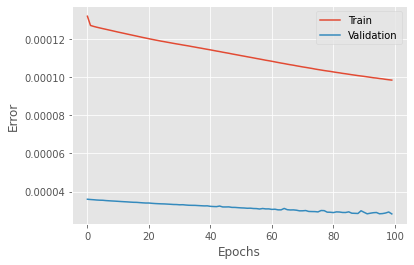

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label = "Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label = "Validation")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [ ]:
correct = 0
total = 0

y_pred = []
y_true = []


columnlist = list(df.columns)[0:-1]+["emotion","label"]
print (columnlist)
correctdf = pd.DataFrame(columns=columnlist)
faildf = pd.DataFrame(columns=columnlist)
correctcount = 0
failcount = 0
for i, ((x, t),(x1)) in enumerate(zip(test_loader,X_test_temp)):
    #print (x[0,:])
    x, t = x.cuda(), t.cuda()  # GPU
    x = x.view(-1,NUM_FEATURES)
    y = model(x)

    #output = (torch.max(torch.exp(y), 1)[1]).data.cpu().numpy()
    output = (y.argmax(1)).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    #print (output)
        
    labels = t.data.cpu().numpy()
    y_true.extend(labels) # Save Truth
    #print (labels)

    correct += (y.argmax(1) == t).sum().item()
    
    if y.argmax(1)==t and correctcount<1001:
      temp = [x1.reshape(1,716).tolist()[0]+[output[0],labels[0]]]
      correctdf = correctdf.append(pd.DataFrame(temp,columns=columnlist))
      correctcount +=1

    elif y.argmax(1)!=t and failcount<1001:
      temp = [x1.reshape(1,716).tolist()[0]+[output[0],labels[0]]]
      #print (temp)
      faildf = faildf.append(pd.DataFrame(temp,columns=columnlist))
      failcount +=1

    total += len(x)
    
print("Accuracy rate:", str(correct/total*100) + "%")

#print(correctdf.head())
#print(faildf.head())

['frame', 'face_id', 'timestamp', 'confidence', 'success', 'gaze_0_x', 'gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z', 'gaze_angle_x', 'gaze_angle_y', 'eye_lmk_x_0', 'eye_lmk_x_1', 'eye_lmk_x_2', 'eye_lmk_x_3', 'eye_lmk_x_4', 'eye_lmk_x_5', 'eye_lmk_x_6', 'eye_lmk_x_7', 'eye_lmk_x_8', 'eye_lmk_x_9', 'eye_lmk_x_10', 'eye_lmk_x_11', 'eye_lmk_x_12', 'eye_lmk_x_13', 'eye_lmk_x_14', 'eye_lmk_x_15', 'eye_lmk_x_16', 'eye_lmk_x_17', 'eye_lmk_x_18', 'eye_lmk_x_19', 'eye_lmk_x_20', 'eye_lmk_x_21', 'eye_lmk_x_22', 'eye_lmk_x_23', 'eye_lmk_x_24', 'eye_lmk_x_25', 'eye_lmk_x_26', 'eye_lmk_x_27', 'eye_lmk_x_28', 'eye_lmk_x_29', 'eye_lmk_x_30', 'eye_lmk_x_31', 'eye_lmk_x_32', 'eye_lmk_x_33', 'eye_lmk_x_34', 'eye_lmk_x_35', 'eye_lmk_x_36', 'eye_lmk_x_37', 'eye_lmk_x_38', 'eye_lmk_x_39', 'eye_lmk_x_40', 'eye_lmk_x_41', 'eye_lmk_x_42', 'eye_lmk_x_43', 'eye_lmk_x_44', 'eye_lmk_x_45', 'eye_lmk_x_46', 'eye_lmk_x_47', 'eye_lmk_x_48', 'eye_lmk_x_49', 'eye_lmk_x_50', 'eye_lmk_x_51', 'eye_lmk_x_52',

In [ ]:
correctdf.to_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/13_predict_emotion_from_face/ekman/model01(3NN_Epoch100)/correct_df.csv")
faildf.to_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/13_predict_emotion_from_face/ekman/model01(3NN_Epoch100)/incorrect_df.csv")

[[   45    27  1866     0     0     5     0]
 [    3   896 15893    37     0     0     0]
 [   19   407 45469   108     0     1     0]
 [    1    92  4445  3748     0     0     0]
 [    1     0    72     0     0     0     0]
 [    4    40  1158     1     0     4     0]
 [    0    11   452     0     0     0     0]]


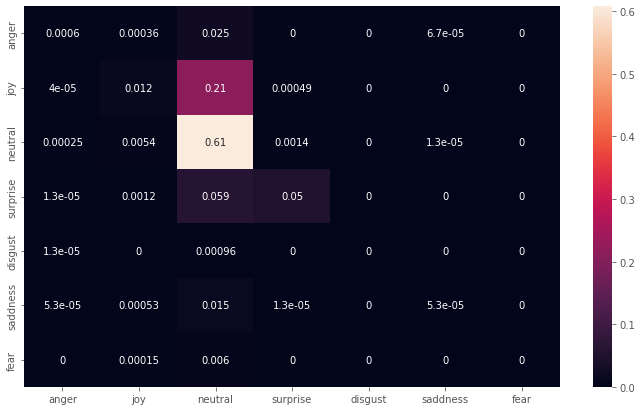

In [ ]:
import seaborn as sn
classes = ('anger', 'joy', 'neutral', 'surprise', 'disgust',
        'saddness', 'fear')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print (cf_matrix)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/05_workspace/01_msc_project/data/output/13_predict_emotion_from_face/ekman/model01(3NN_Epoch100)/pytorch_epoch100_model.pth")